## Scenario 2: building a model trained on both stream gauges and HWMs

### a) Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
import h5py
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
import random as rn
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import shap
import warnings



# Set random seeds for reproducibility
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)

### b) Reading the stream gauges and HWM data for hurricane Ida

In [2]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Ida.csv', header=0)

# Set 'Distance to river' and 'HAND' to 0 where 'Type' is 'Stream'
df.loc[df['Type'] == 'Stream', 'Distance to river'] = 0
df.loc[df['Type'] == 'Stream', 'HAND'] = 0

df

,FID,Shape,site_no,latitude,longitude,Uncertainty,Type,Flood,Altitude,Rain,...,Soil moisture,Slope,Curvature,Flow accumulation,TWI,Distance to river,Distance to storm track,Distance to sea,Tide,Mean gauge height
0,0,Point,NJHUN31738,40.503925,-74.865608,0.2,HWMs,1.000000,54.3457,249.6,...,0.428718,0.918132,6191200000,0,-17.601400,0.002459,0.471748,0.594653,1.376270,0.000000
1,1,Point,NJHUN31738,40.503248,-74.865348,0.1,HWMs,2.600000,53.9004,249.6,...,0.428718,0.720335,-83546900,0,-26.235500,0.002509,0.471026,0.594372,1.376520,0.000000
2,2,Point,NJHUN31738,40.503140,-74.864977,0.4,HWMs,2.800000,53.5673,249.6,...,0.428718,1.039240,-655878000,2,0.407577,0.002828,0.470819,0.593998,1.376840,0.000000
3,3,Point,NJHUN31738,40.503246,-74.864752,0.2,HWMs,1.600000,54.3039,249.6,...,0.428718,0.729352,-3452240000,3,1.229210,0.003076,0.470858,0.593776,1.377030,0.000000
4,4,Point,NJSOM31515,40.404814,-74.681513,0.2,HWMs,7.300000,21.0319,226.2,...,0.428718,0.670430,1213090000,0,-29.038100,0.000941,0.325321,0.417992,1.313770,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,352,Point,1374505,41.394583,-73.607472,0.0,Stream,2.502708,101.3900,142.8,...,0.279366,12.305600,-1685520000,4,-5.195090,0.000000,0.979721,0.370593,0.935456,3.757292
353,353,Point,1374531,41.373389,-73.639583,0.0,Stream,5.177292,84.5413,142.9,...,0.352202,1.420260,-1222070000,61,0.623553,0.000000,0.967796,0.360568,0.953227,2.472708
354,354,Point,1374781,41.327361,-73.591472,0.0,Stream,2.503854,104.1990,155.6,...,0.258539,5.531940,203999000,20,-3.207680,0.000000,0.910662,0.303099,0.978951,2.266146
355,355,Point,1374559,41.470472,-73.759583,0.0,Stream,2.766563,183.4710,129.8,...,0.381326,14.157900,3799270000,69,-0.087799,0.000000,1.093210,0.481995,0.902405,1.503437


### d) Defining features and the target variable

In [3]:
# List of feature pairs for interaction terms
feature_pairs = [
    ("Rain", "Curvature"),
    ("Rain", "Distance to river"),
    ("Rain", "Distance to storm track"),
    ("Rain", "Mean gauge height"),
    ("HAND", "Distance to sea"),
    ("HAND", "Mean gauge height"),
    ("Wind speed", "Soil moisture"),
    ("Wind speed", "Distance to river"),
    ("Wind speed", "Tide"),
    ("Soil moisture", "Tide"),
    ("Soil moisture", "Distance to sea"),
    ("Soil moisture", "Mean gauge height"),
    ("Slope", "Tide"),
    ("Slope", "Mean gauge height"),
    ("Curvature", "Tide"),
    ("Flow accumulation", "Tide"),
    ("Flow accumulation", "Mean gauge height"),
    ("Distance to river", "Tide"),
    ("Distance to river", "Mean gauge height"),
    ("Tide", "Mean gauge height"),
    ("Distance to storm track", "Distance to sea"),
    ("Distance to storm track", "Mean gauge height")
]

# Create the interaction features
for pair in feature_pairs:
    feature1, feature2 = pair
    interaction_term_name = f"{feature1}:{feature2}"
    df[interaction_term_name] = df[feature1] * df[feature2]


In [4]:
features= [
    "Wind speed",
    "Soil moisture",
    "Slope",
    "Curvature",
    "Flow accumulation",
    "Distance to river",
    "Distance to storm track",
    "Distance to sea",
    "Rain:Curvature",
    "Rain:Distance to river",
    "Rain:Distance to storm track",
    "Rain:Mean gauge height",
    "HAND:Distance to sea",
    "HAND:Mean gauge height",
    "Wind speed:Soil moisture",
    "Wind speed:Distance to river",
    "Wind speed:Tide",
    "Soil moisture:Tide",
    "Soil moisture:Distance to sea",
    "Soil moisture:Mean gauge height",
    "Slope:Tide",
    "Slope:Mean gauge height",
    "Curvature:Tide",
    "Flow accumulation:Tide",
    "Flow accumulation:Mean gauge height",
    "Distance to river:Tide",
    "Distance to river:Mean gauge height",
    "Tide:Mean gauge height",
    "Distance to storm track:Distance to sea",
    "Distance to storm track:Mean gauge height"
]

x = df[features].copy()


y = df['Flood']* 0.3048  #ft to m
x.shape

(357, 30)

### e) Splitting and scaling data

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = scaler.fit_transform(x)


# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.2, random_state=64)

### f) Create a model 

In [14]:
# Define the input layer
inputs = tf.keras.Input(shape=(Xtrain.shape[1]))

# Define the hidden layers
hidden = tf.keras.layers.Dense(
    16, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(inputs)
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.Dense(
    32, activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.1))(hidden)
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.Dense(
    16, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(hidden)
hidden = tf.keras.layers.BatchNormalization()(hidden)

# Define the output layer. Make sure the output dimension is correct.
outputs = tf.keras.layers.Dense(1, activation='relu')(hidden) # Ensures output is non-negative

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)


model.summary()


#Define the learning rate schedule
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=50,
    decay_rate=0.92,
    staircase=True
)

opt = tf.keras.optimizers.Adam(learning_rate=lr)


# Define a custom callback function
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] <0.46 and logs['loss']<0.46:
            self.model.stop_training = True

# Create an instance of the custom callback
custom_early_stopping = CustomEarlyStopping()


# Compile the model
model.compile(
    optimizer= opt, 
    loss='mean_absolute_error'
#    metrics=['accuracy']
)
model_checkpoint = ModelCheckpoint('model.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True)
# Train your model
history = model.fit(
    Xtrain,
    Ytrain,
    batch_size=64,
    epochs=2000,
    validation_data=(Xtest, Ytest),
    callbacks=[custom_early_stopping, model_checkpoint]
)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_16 (Dense)            (None, 16)                496       
                                                                 
 batch_normalization_12 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 32)                544       
                                                                 
 batch_normalization_13 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 16)                528 

Epoch 148/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.4470 - val_loss: 0.6778
Epoch 149/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.4031 - val_loss: 0.6165
Epoch 150/2000
5/5 [==============================] - 0s 26ms/step - loss: 0.3931 - val_loss: 0.5111
Epoch 151/2000
5/5 [==============================] - 0s 28ms/step - loss: 0.4028 - val_loss: 0.4976
Epoch 152/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.3893 - val_loss: 0.5147
Epoch 153/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.3611 - val_loss: 0.5110
Epoch 154/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.3982 - val_loss: 0.5119
Epoch 155/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.4029 - val_loss: 0.5109
Epoch 156/2000
5/5 [==============================] - 0s 24ms/step - loss: 0.3764 - val_loss: 0.4771
Epoch 157/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.3730 - val_loss: 0

### Evaluating model performance on both the training and test data.

In [7]:
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

# Evaluate the model on the test set
Ytrain_pred = model.predict(Xtrain)
Ytest_pred = model.predict(Xtest)


print("R-squared for train: {:.2f}".format(r2_score(Ytrain, Ytrain_pred)))
print("R-squared for test: {:.2f}".format(r2_score(Ytest, Ytest_pred)))
print("MAE for train: {:.2f}".format(metrics.mean_absolute_error(Ytrain, Ytrain_pred)))
print("MAE for test: {:.2f}".format(metrics.mean_absolute_error(Ytest, Ytest_pred)))
print("Median Absolute Error for train: {:.2f}".format(median_absolute_error(Ytrain, Ytrain_pred)))
print("Median Absolute Error for test: {:.2f}".format(median_absolute_error(Ytest, Ytest_pred)))
print("Normalized Root Mean Square Error for train: {:.2f}".format(np.sqrt(mean_squared_error(Ytrain, Ytrain_pred))*100 / (np.mean(Ytrain))))
print("Normalized Root Mean Square Error for test: {:.2f}".format(np.sqrt(mean_squared_error(Ytest, Ytest_pred))*100 / (np.mean(Ytest))))

R-squared for train: 0.76
R-squared for test: 0.74
MAE for train: 0.34
MAE for test: 0.40
Median Absolute Error for train: 0.21
Median Absolute Error for test: 0.30
Normalized Root Mean Square Error for train: 60.29
Normalized Root Mean Square Error for test: 59.37


In [11]:
import shap
import matplotlib.pyplot as plt

#set the features names
features2= features

# Define a function to wrap the Keras model for compatibility with SHAP
def keras_model_wrapper(x):
    return model.predict(x).flatten()

explainer = shap.KernelExplainer(keras_model_wrapper, Xtrain)
shap_values = explainer.shap_values(Xtest)


# Initialize SHAP's JavaScript visualization
shap.initjs()

9/9 [==============================] - 0s 1ms/step


Using 285 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/72 [00:00<?, ?it/s]

18846/18846 [==============================] - 19s 1ms/step


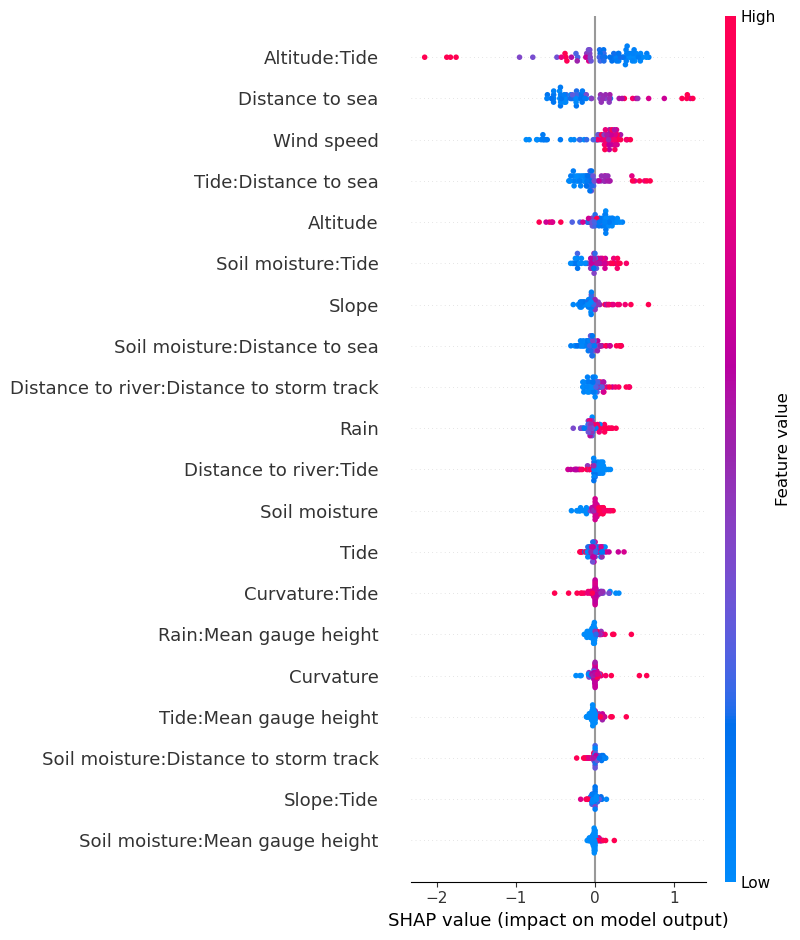

In [12]:
# Generate the SHAP summary plot
shap.summary_plot(shap_values, Xtest, feature_names=features2)

### Save the model

In [8]:
# Specify the path and filename for the model
model_path = 'Scenario2.h5'

# Use the .save() method to save your model
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to Scenario2.h5


### Scatter plots

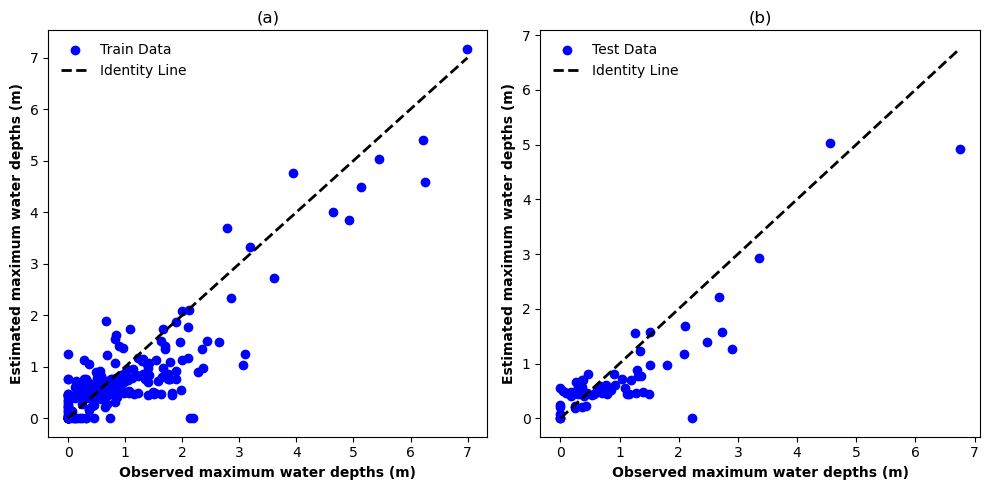

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scatter plot for simulated vs observed max flood depths (Train Data)
axes[0].scatter(Ytrain, Ytrain_pred, color='blue', label='Train Data')
axes[0].plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=2, label='Identity Line')
axes[0].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[0].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[0].set_title('(a)')
axes[0].legend(frameon=False)  # No legend box

# Scatter plot for simulated vs observed max flood depths (Test Data)
axes[1].scatter(Ytest, Ytest_pred, color='blue', label='Test Data')
axes[1].plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--', lw=2, label='Identity Line')
axes[1].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[1].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[1].set_title('(b)')
axes[1].legend(frameon=False)  # No legend box

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Evaluating stream gauges, HWMs, and stream gagues + HWMs

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

def evaluate_model(predictions, actuals, model_name):
    # Flatten predictions if necessary
    predictions = predictions
    
    # Calculate metrics
    r_squared = np.round(r2_score(actuals, predictions), 2)
    mae = mean_absolute_error(actuals, predictions)
    mdae = median_absolute_error(actuals, predictions)
    nrmse = np.sqrt(mean_squared_error(actuals, predictions)) * 100 / np.mean(actuals)
    bias = np.mean(predictions - actuals)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # Prepare DataFrame
    errors_df = pd.DataFrame({
        "Metric": ["R-squared", "MAE", "Median Absolute Error", "NRMSE", "BIAS", "RMSE"],
        "Value": [r_squared, mae, mdae, nrmse, bias, rmse]
    })
    
    # Print the DataFrame to check
    print(f"Errors for {model_name}:")
    print(errors_df)

    # Save to CSV
    errors_df.to_csv(f"errors_{model_name}.csv", index=False)

    return errors_df


In [24]:
# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_t = df['Flood'] * 0.3048 

# Ensure 'features' contains the correct column names you want to use for the model
x_t = df[features].copy()

# Scale the data
x_t_scaled = scaler.fit_transform(x_t)

# Assuming 'best_model' is already trained and ready to be used for predictions
y_t_pred = model.predict(x_t_scaled).flatten()


errors_df_t = evaluate_model(y_t_pred, y_t, "Overall_S2")


# First, add y_t and y_t_pred to your DataFrame if they aren't already included
df['y_t'] = y_t
df['y_t_pred'] = y_t_pred



# Correct filtering of the DataFrame based on 'Type'
df_strm = df[df['Type'] == 'Stream']

# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_strm = df_strm['y_t']  
y_strm_pred = df_strm['y_t_pred'] 

errors_df_strm = evaluate_model(y_strm_pred, y_strm, "Stream_S2")


# Correct filtering of the DataFrame based on 'Type'
df_HWM = df[df['Type'] == 'HWMs']

# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_HWM = df_HWM['y_t']  
y_HWM_pred = df_HWM['y_t_pred'] 

errors_df_HWM = evaluate_model(y_HWM_pred, y_HWM, "HWMs_S2")

12/12 [==============================] - 0s 1ms/step
Errors for Overall_S2:
                  Metric      Value
0              R-squared   0.750000
1                    MAE   0.353846
2  Median Absolute Error   0.231692
3                  NRMSE  60.146575
4                   BIAS  -0.131620
5                   RMSE   0.529339
Errors for Stream_S2:
                  Metric      Value
0              R-squared   0.780000
1                    MAE   0.518448
2  Median Absolute Error   0.393114
3                  NRMSE  37.832935
4                   BIAS  -0.254018
5                   RMSE   0.694037
Errors for HWMs_S2:
                  Metric      Value
0              R-squared   0.120000
1                    MAE   0.290685
2  Median Absolute Error   0.198684
3                  NRMSE  87.655705
4                   BIAS  -0.084653
5                   RMSE   0.450427


In [28]:
# Create a DataFrame
data = {
    'site_no': df_strm['site_no'],
    'Actual': y_strm,  
    'Predicted': y_strm_pred,  # Flatten the Ytrain_pred array
    'Absolute_Error': abs(y_strm_pred- y_strm),
    'Error': y_strm_pred- y_strm,
    'FQ': y_strm_pred*100/y_strm
}


# Create a new DataFrame
output_df = pd.DataFrame(data)


# Save the new DataFrame to a CSV file
output_df.to_csv('Scenario2_strm_Prediction.csv', index=False)

In [30]:
# Create a DataFrame
data = {
    'site_no': df_HWM['site_no'],
    'Actual': y_HWM,  
    'Predicted': y_HWM_pred,  # Flatten the Ytrain_pred array
    'Absolute_Error': abs(y_HWM_pred- y_HWM),
    'Error': y_HWM_pred- y_HWM,
    'FQ': y_HWM_pred*100/y_HWM
}


# Create a new DataFrame
output_df = pd.DataFrame(data)


# Save the new DataFrame to a CSV file
output_df.to_csv('Scenario2_HWMs_Prediction.csv', index=False)

## Transferability

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error


# Read the CSV file into a pandas DataFrame
df_Ian = pd.read_csv('Ian.csv', header=0)



# Create the interaction features
for pair in feature_pairs:
    feature1, feature2 = pair
    interaction_term_name = f"{feature1}:{feature2}"
    df_Ian[interaction_term_name] = df_Ian[feature1] * df_Ian[feature2]


x_Ian = df_Ian[features].copy()

y_Ian = df_Ian['Flood']* 0.3048  

# Scale the data
x_Ian_scaled = scaler.fit_transform(x_Ian)


# Evaluate the model on the test set
y_Ian_pred = model.predict(x_Ian_scaled)


print("R-squared for Ian:{}".format(np.round(r2_score(y_Ian, y_Ian_pred), 2)))
print("MAE for Ian: {:.2f}".format(mean_absolute_error(y_Ian, y_Ian_pred)))
print("Median Absolute Error for Ian: {:.2f}".format(median_absolute_error(y_Ian, y_Ian_pred)))
print("Root mean square error for Ian: {}". format(np.round(np.sqrt(mean_squared_error(y_Ian, y_Ian_pred)), 2)))
print("BIAS for Ian: {:.2f}".format(np.mean(y_Ian_pred - y_Ian.values.flatten())))
print("Normalized Root Mean Square Error for Ian: {:.2f}".format(np.sqrt(mean_squared_error( y_Ian, y_Ian_pred))*100 / ( np.mean(y_Ian))))

R-squared for Ian:-0.61
MAE for Ian: 0.61
Median Absolute Error for Ian: 0.43
Root mean square error for Ian: 0.85
BIAS for Ian: -0.43
Normalized Root Mean Square Error for Ian: 98.02


In [11]:
# Read the CSV file into a pandas DataFrame
df_Michael = pd.read_csv('Micheal.csv', header=0)


# Create the interaction features
for pair in feature_pairs:
    feature1, feature2 = pair
    interaction_term_name = f"{feature1}:{feature2}"
    df_Michael[interaction_term_name] = df_Michael[feature1] * df_Ian[feature2]

x_Michael = df_Michael[features].copy()

y_Michael = df_Michael['Flood']* 0.3048 

# Scale the data
x_Michael_scaled = scaler.fit_transform(x_Michael)


# Evaluate the model on the test set
y_Michael_pred = model.predict(x_Michael_scaled).flatten()

# Calculate R-squared
r_squared = r2_score(y_Michael, y_Michael_pred)


print("R-squared for Michael:{}".format(np.round(r_squared, 2)))
print("MAE for Michael: {:.2f}".format(mean_absolute_error(y_Michael, y_Michael_pred)))
print("MedMichael Absolute Error for Michael: {:.2f}".format(median_absolute_error(y_Michael, y_Michael_pred)))
print("Root mean square error for Michael: {}". format(np.round(np.sqrt(mean_squared_error(y_Michael, y_Michael_pred)), 2)))
print("BIAS for Michael: {:.2f}".format(np.mean(y_Michael_pred - y_Michael.values.flatten())))
print("Normalized Root Mean Square Error for Michael: {:.2f}".format(np.sqrt(mean_squared_error( y_Michael, y_Michael_pred))*100 / ( np.mean(y_Michael))))

R-squared for Michael:-0.5
MAE for Michael: 0.70
MedMichael Absolute Error for Michael: 0.50
Root mean square error for Michael: 0.9
BIAS for Michael: -0.48
Normalized Root Mean Square Error for Michael: 105.28
